# Aquabreeding software for simulating aquaculture breeding
Simulation includes the following steps:
- A founder population is generated.  The numbers of females and males, chromosome number, size, and crossing-over rates in females and males should be set.  In this version, all chromosomes are the same size, and the crossing-over rate is flat across the genome.
- SNPs of the founder population are generated by coalescent simulation.  This version allows only a standard Wright-Fisher model.  The two types of SNPs are simulated. One affects the phenotype, and the others are neutral and used for GBLUP.
- The effect sizes of the SNPs on the phenotype follow a normal distribution with mean 0 and user-defined variance.
- A progeny population is produced by crossing the individuals of the founder population. The available mating schemes are partial factorial (1 x 1, 1 x 2, 1 x 3,...), full factorial and user-defined mating design.
- The phenotypic values of the progeny individuals are calculated by summing the true breeding values and the environmental effects, the latter of which follows a normal distribution with mean 0 and user-defined variance.
- The breeding values of the progeny individuals are estimated by ABLUP with a numerator relationship matrix or GBLUP with a genomic relationship matrix.  A restricted maximum likelihood method is applied to estimate breeding values and the variance components (additive and residual variance).
- The founder population of the next generation is selected by mass selection or within-family selection based on estimated breeding values or phenotypic values.
- These processes are repeated until a user is satisfied.

## Parameter setting
These parameters have to be set before running the simulation.
- founder_size: tuple(The numbers of females and males of a founder population). The numbers of females and males must be the same to use the implemented mating designs.
- progeny_size: tuple(The numbers of females and males of a progeny population). Less than 1,000 in total is recommended.
- chrom: tuple(the number of chromosomes, chromosome length (bp), crossing-over rate in females (cM/Mb), and in males (cM/Mb)}.
- n_snp: The number of SNPs with effects on the phenotype in a founder population.
- mean_phenotype: Mean phenotypic value.
- effect_var: The variance value of the effect sizes of SNPs.
- residual_var: The variance value of environmental factor.
- gblup: The number of SNPs for GBLUP.  Less than 10,000 is recommended.

## Output
Some statistics of the progeny population are obtained:
- Phenotypic values
- True breeding values
- Estimated breeding values
- Estimated additive genetic and residual variance values
- Inbreeding coefficient (the proportion of identity-by-descent segments)

## To-Do list
- All SNPs have only additive effects.  Dominance and epistasis will be incorporated.
- Founders from structured population.
- Multiple phenotypes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import aquabreeding as aq

def hist_3g(pan, g_max, tag):
    gen = [f'F{i+1}' for i in range(g_max)]
    print(gen)
    fig, ax = plt.subplots(figsize = (4, 3))
    sns.histplot(pan, x=tag, hue='Generation', hue_order=reversed(gen), bins=20, palette='Set2', element='step', alpha=0.8, ax=ax)
    plt.legend(labels=gen, loc=2, bbox_to_anchor=(1, 0.7))
    plt.show()

## How to use

### Mass selection

['F1', 'F2', 'F3']


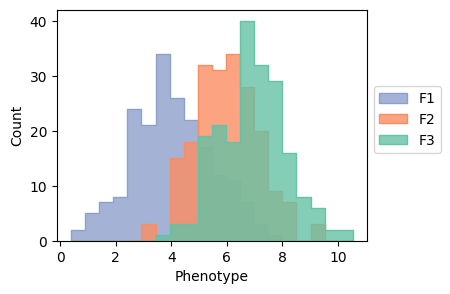

In [2]:
# Simulate mass selection with ABLUP

# results are stored in pandas DataFrame
cols = ['Phenotype', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua = aq.AquaBreeding(founder_size=(10, 10),
                       progeny_size=(100, 100),
                       chrom=(2, 100_000_000, 2.0, 2.0),
                       n_snp=50,
                       mean_phenotype=4.0,
                       effect_var=0.15,
                       residual_var=0.4)
aqua.snp_standard()
aqua.mating_design(cross_design='1x2')  # 1x1, 1x2, 1x3,..., full

g_max = 3  # simulate from F1 to F3

for g in range(g_max):  
    aqua.mating()
    aqua.breeding_value(blup='ABLUP')
    # get phenotype data of the progeny population
    phe_ls = aqua.get_phenotype()
    record = pd.DataFrame([phe_ls, [f'F{g+1}']*len(phe_ls)]).transpose()
    record.columns = cols
    df1 = pd.concat([df1, record], ignore_index=True)
    if g == g_max-1:  # last generation
        break
    # target can be bv (breeding value), phenotype, of random
    aqua.selection(target='bv', method='mass')
    
hist_3g(df1, g_max, 'Phenotype')

### Within-family selection

['F1', 'F2', 'F3']


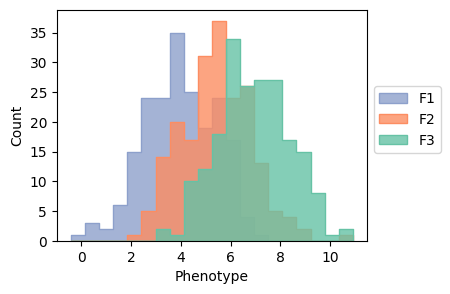

In [7]:
# Simulate within-family selection with ABLUP

# results are stored in pandas DataFrame
cols = ['Phenotype', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua = aq.AquaBreeding(founder_size=(10, 10),
                       progeny_size=(100, 100),
                       chrom=(2, 100_000_000, 2.0, 2.0),
                       n_snp=50,
                       mean_phenotype=4.0,
                       effect_var=0.15,
                       residual_var=0.4)
aqua.snp_standard()
aqua.mating_design(cross_design='1x2')

g_max = 3  # simulate from F1 to F3

for g in range(g_max):  
    aqua.mating()
    aqua.breeding_value(blup='ABLUP')
    # get phenotype data of the progeny population
    phe_ls = aqua.get_phenotype()
    record = pd.DataFrame([phe_ls, [f'F{g+1}']*len(phe_ls)]).transpose()
    record.columns = cols
    df1 = pd.concat([df1, record], ignore_index=True)
    if g == g_max-1:  # last generation
        break
    aqua.selection(target='bv', method='within-family')  ######
    
hist_3g(df1, g_max, 'Phenotype')

['F1', 'F2', 'F3']


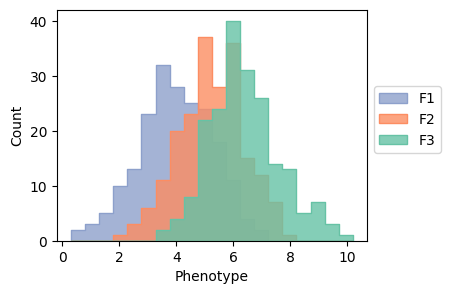

In [8]:
# Simulate within-family selection with ABLUP
# Next founders are selected from progenies with top X% breeding values

# results are stored in pandas DataFrame
cols = ['Phenotype', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua = aq.AquaBreeding(founder_size=(10, 10),
                       progeny_size=(100, 100),
                       chrom=(2, 100_000_000, 2.0, 2.0),
                       n_snp=50,
                       mean_phenotype=4.0,
                       effect_var=0.15,
                       residual_var=0.4)
aqua.snp_standard()
aqua.mating_design(cross_design='1x2')

g_max = 3  # simulate from F1 to F3

for g in range(g_max):  
    aqua.mating()
    aqua.breeding_value(blup='ABLUP')
    # get phenotype data of the progeny population
    phe_ls = aqua.get_phenotype()
    record = pd.DataFrame([phe_ls, [f'F{g+1}']*len(phe_ls)]).transpose()
    record.columns = cols
    df1 = pd.concat([df1, record], ignore_index=True)
    if g == g_max-1:  # last generation
        break
    # Parents are selected from progenies with top 40% breeding values
    aqua.selection(target='bv', method='within-family', top_prop=0.4)  ######
    
hist_3g(df1, g_max, 'Phenotype')

### Family selection

['F1', 'F2', 'F3']


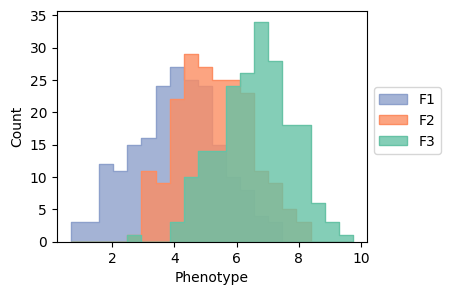

In [4]:
# Simulate family selection with ABLUP
# Set no. families to be selected

# results are stored in pandas DataFrame
cols = ['Phenotype', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua = aq.AquaBreeding(founder_size=(10, 10),
                       progeny_size=(100, 100),
                       chrom=(2, 100_000_000, 2.0, 2.0),
                       n_snp=50,
                       mean_phenotype=4.0,
                       effect_var=0.15,
                       residual_var=0.4)
aqua.snp_standard()
aqua.mating_design(cross_design='1x2')

g_max = 3  # simulate from F1 to F3

for g in range(g_max):  
    aqua.mating()
    aqua.breeding_value(blup='ABLUP')
    # get phenotype data of the progeny population
    phe_ls = aqua.get_phenotype()
    record = pd.DataFrame([phe_ls, [f'F{g+1}']*len(phe_ls)]).transpose()
    record.columns = cols
    df1 = pd.concat([df1, record], ignore_index=True)
    if g == g_max-1:  # last generation
        break
    aqua.selection(target='bv', method='family', n_family=10)  ######
    
hist_3g(df1, g_max, 'Phenotype')

### Custom mating design

['F1', 'F2', 'F3']


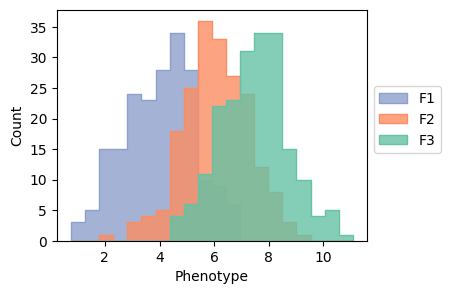

In [5]:
# Simulate mass selection with ABLUP
# Custom mating design
# 1st col: female index, 2nd col: male index, 3rd and 4th col: 0
custom_d = np.array([[0, 0, 0, 0], [0, 1, 0, 0], [0, 2, 0, 0],
                     [1, 2, 0, 0], [1, 3, 0, 0], [1, 4, 0, 0]])

# results are stored in pandas DataFrame
cols = ['Phenotype', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua = aq.AquaBreeding(founder_size=(2, 5),
                       progeny_size=(100, 100),
                       chrom=(2, 100_000_000, 2.0, 2.0),
                       n_snp=50,
                       mean_phenotype=4.0,
                       effect_var=0.15,
                       residual_var=0.4)
aqua.snp_standard()
aqua.mating_design(custom_design=custom_d)  ######

g_max = 3  # simulate from F1 to F3

for g in range(g_max):  
    aqua.mating()
    aqua.breeding_value(blup='ABLUP')
    # get phenotype data of the progeny population
    phe_ls = aqua.get_phenotype()
    record = pd.DataFrame([phe_ls, [f'F{g+1}']*len(phe_ls)]).transpose()
    record.columns = cols
    df1 = pd.concat([df1, record], ignore_index=True)
    if g == g_max-1:  # last generation
        break
    aqua.selection(target='bv', method='mass')
    
hist_3g(df1, g_max, 'Phenotype')

### GBLUP

['F1', 'F2', 'F3']


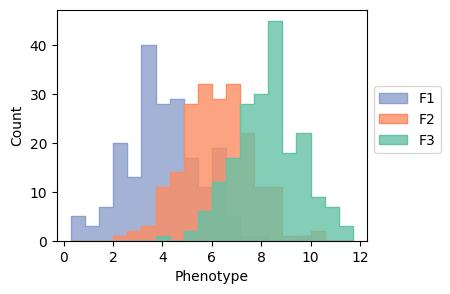

In [81]:
# Simulate mass selection with GBLUP

# results are stored in pandas DataFrame
cols = ['Phenotype', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua = aq.AquaBreeding(founder_size=(10, 10),
                       progeny_size=(100, 100),
                       chrom=(2, 100_000_000, 2.0, 2.0),
                       n_snp=50,
                       mean_phenotype=4.0,
                       effect_var=0.15,
                       residual_var=0.4,
                       gblup=1000)  ######
aqua.snp_standard()
aqua.mating_design(cross_design='1x2')

g_max = 3  # simulate from F1 to F3

for g in range(g_max):  
    aqua.mating()
    aqua.breeding_value(blup='GBLUP')  ######
    # get phenotype data of the progeny population
    phe_ls = aqua.get_phenotype()
    record = pd.DataFrame([phe_ls, [f'F{g+1}']*len(phe_ls)]).transpose()
    record.columns = cols
    df1 = pd.concat([df1, record], ignore_index=True)
    if g == g_max-1:  # last generation
        break
    aqua.selection(target='bv', method='mass')
    
hist_3g(df1, g_max, 'Phenotype')

### Mass vs. Within-family selection

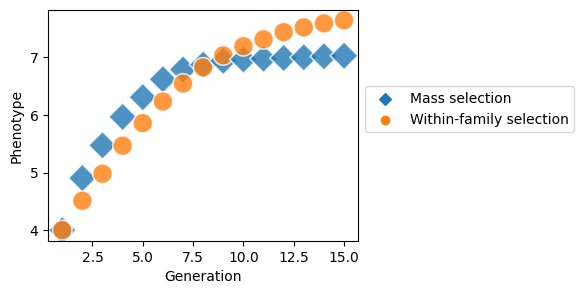

In [11]:
# CAUSION: it takes minutes
# Phenotype changes with mass and within-family-selection

n_rep = 20  # num replicate
g_max = 15  # generation

# results are stored in pandas DataFrame
cols = ['phenotype', 'generation', 'tag']
df1 = pd.DataFrame(index=[], columns=cols)

# mass selection
for i in range(n_rep):
    aqua = aq.AquaBreeding(founder_size=(5, 5), 
                           progeny_size=(50, 50), 
                           chrom=(2, 100_000_000, 1.0, 1.0),
                           n_snp=20,
                           mean_phenotype=4.0,
                           effect_var=0.08, 
                           residual_var=0.12)
    aqua.snp_standard()
    aqua.mating_design(cross_design='1x2')

    for g in range(g_max):
        aqua.mating()
        aqua.breeding_value(blup='ABLUP')
        
        # get phenotype data
        tmp_p = aqua.get_phenotype()
        record = pd.DataFrame([[np.mean (tmp_p), g, 'Mass selection']], columns=cols)
        df1 = pd.concat([df1, record], ignore_index=True)
        
        if g == g_max-1:
            break
        aqua.selection(target='bv', method='mass')

# within family selection
for i in range(n_rep): 
    aqua = aq.AquaBreeding(founder_size=(5, 5), 
                           progeny_size=(50, 50), 
                           chrom=(2, 100_000_000, 1.0, 1.0),
                           n_snp=20,
                           mean_phenotype=4.0,
                           effect_var=0.08, 
                           residual_var=0.12)
    aqua.snp_standard()
    aqua.mating_design(cross_design='1x2')

    for g in range(g_max):
        aqua.mating()
        aqua.breeding_value(blup='ABLUP')
        
        # get phenotype data
        tmp_p = aqua.get_phenotype()
        record = pd.DataFrame([[np.mean (tmp_p), g, 'Within-family selection']], columns=cols)
        df1 = pd.concat([df1, record], ignore_index=True)
        
        if g == g_max-1:
            break
        aqua.selection(target='bv', method='within-family')

cols = ['Generation', 'Phenotype', 'tag']
df2 = pd.DataFrame(index=[], columns=cols)
for g in range(g_max):
    for j in ['Mass selection', 'Within-family selection']:
        tmp = df1[(df1['generation']==g) & (df1['tag']==j)]
        mean_phe = np.mean(tmp['phenotype'])
        record = pd.DataFrame([[g+1, mean_phe, j]], columns=cols)
        df2 = pd.concat([df2, record], ignore_index=True)
fig, ax = plt.subplots(figsize = (4, 3))
sns.scatterplot(x="Generation", y="Phenotype", hue="tag", style='tag', markers=('D', 'o'), s=200, alpha=0.8, data=df2, ax=ax)
plt.legend(loc=2, bbox_to_anchor=(1, 0.7))
plt.show()

# Estimated breeding values and variance components

Estimated additive genetic variance = 0.5834116289087266
Estimated residual variance         = 0.4684467010694069
Heritability                        = 0.5546484847639651


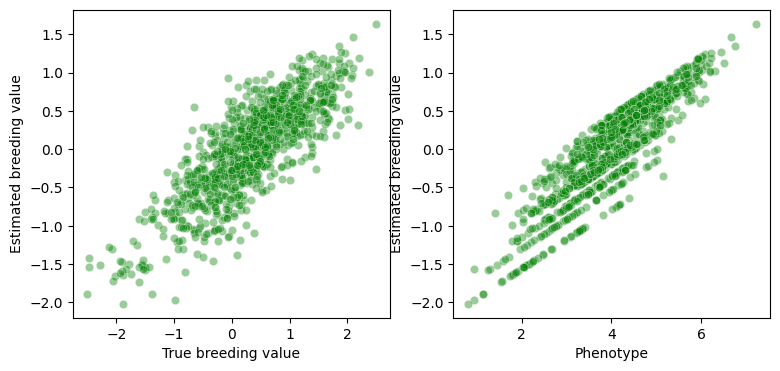

In [74]:
aqua = aq.AquaBreeding(founder_size=(10, 10),
                       progeny_size=(500, 500),
                       chrom=(2, 100_000_000, 2.0, 2.0),
                       n_snp=50,
                       mean_phenotype=4.0,
                       effect_var=0.08,
                       residual_var=0.4)
aqua.snp_standard()
aqua.mating_design(cross_design='1x2')
aqua.mating()
aqua.breeding_value(blup='ABLUP')

vg, ve = aqua.variance_component()
print(f'Estimated additive genetic variance = {vg}')
print(f'Estimated residual variance         = {ve}')
print(f'Heritability                        = {vg/(vg+ve)}')

# true breeding value
tbv = aqua.get_true_bv()
# estimated breeding value
ebv = aqua.get_ebv()
# phynotypes
phenotype = aqua.get_phenotype()

df = pd.DataFrame([tbv, ebv, phenotype]).transpose()
df.columns = ['True breeding value', 'Estimated breeding value', 'Phenotype']

#print (pbv)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
sns.scatterplot(x='True breeding value', y='Estimated breeding value', c='g', alpha=0.4, data=df, ax=axes[0])
sns.scatterplot(x='Phenotype', y='Estimated breeding value', c='g', alpha=0.4, data=df, ax=axes[1])
plt.show ()

# Inbreeding coefficient

['F1', 'F2', 'F3', 'F4', 'F5']


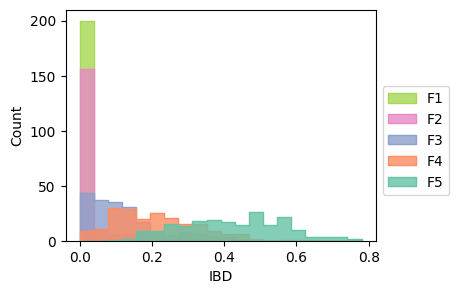

In [15]:
# Calculate inbreeding coefficient

# results are stored in pandas DataFrame
cols = ['IBD', 'Generation']
df1 = pd.DataFrame(index=[], columns=cols)

# start new simulation
# initial setting
aqua = aq.AquaBreeding(founder_size=(10, 10),
                       progeny_size=(100, 100),
                       chrom=(2, 100_000_000, 2.0, 2.0),
                       n_snp=50,
                       mean_phenotype=4.0,
                       effect_var=0.15,
                       residual_var=0.4)
aqua.snp_standard()
aqua.mating_design(cross_design='1x2')  # 1x1, 1x2, 1x3,..., full

g_max = 5  # simulate from F1 to F3

for g in range(g_max):  
    aqua.mating()
    aqua.breeding_value(blup='ABLUP')
    # get inbreeding coefficient of the progeny population
    ibd_ls = aqua.get_ibd()
    record = pd.DataFrame([ibd_ls, [f'F{g+1}']*len(ibd_ls)]).transpose()
    record.columns = cols
    df1 = pd.concat([df1, record], ignore_index=True)
    if g == g_max-1:  # last generation
        break
    # target can be bv (breeding value), phenotype, of random
    aqua.selection(target='bv', method='mass')
    
hist_3g(df1, g_max, 'IBD')

### Mass vs. Within-family selection

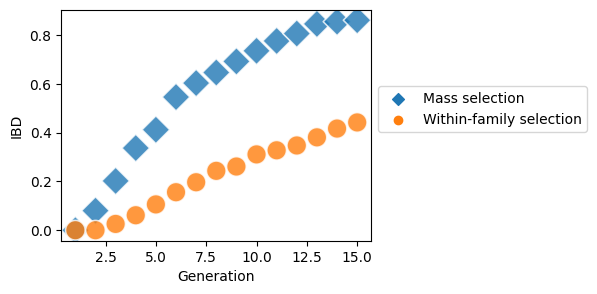

In [17]:
# CAUSION: it takes minutes
# Phenotype changes with mass and within-family-selection

n_rep = 10  # num replicate
g_max = 15  # generation

# results are stored in pandas DataFrame
cols = ['IBD', 'Generation', 'tag']
df1 = pd.DataFrame(index=[], columns=cols)

# mass selection
for i in range(n_rep):
    aqua = aq.AquaBreeding(founder_size=(5, 5), 
                           progeny_size=(50, 50), 
                           chrom=(3, 100_000_000, 1.0, 1.0),
                           n_snp=20,
                           mean_phenotype=4.0,
                           effect_var=0.08, 
                           residual_var=0.12)
    aqua.snp_standard()
    aqua.mating_design(cross_design='1x2')

    for g in range(g_max):
        aqua.mating()
        aqua.breeding_value(blup='ABLUP')
        
        # get phenotype data
        tmp_p = aqua.get_ibd()
        record = pd.DataFrame([[np.mean(tmp_p), g, 'Mass selection']], columns=cols)
        df1 = pd.concat([df1, record], ignore_index=True)
        
        if g == g_max-1:
            break
        aqua.selection(target='bv', method='mass')

# within family selection
for i in range(n_rep): 
    aqua = aq.AquaBreeding(founder_size=(5, 5), 
                           progeny_size=(50, 50), 
                           chrom=(3, 100_000_000, 1.0, 1.0),
                           n_snp=20,
                           mean_phenotype=4.0,
                           effect_var=0.08, 
                           residual_var=0.12)
    aqua.snp_standard()
    aqua.mating_design(cross_design='1x2')

    for g in range(g_max):
        aqua.mating()
        aqua.breeding_value(blup='ABLUP')
        
        # get phenotype data
        tmp_p = aqua.get_ibd()
        record = pd.DataFrame([[np.mean(tmp_p), g, 'Within-family selection']], columns=cols)
        df1 = pd.concat([df1, record], ignore_index=True)
        
        if g == g_max-1:
            break
        aqua.selection(target='bv', method='within-family', top_prop=1.0)

cols = ['Generation', 'IBD', 'tag']
df2 = pd.DataFrame(index=[], columns=cols)
for g in range(g_max):
    for j in ['Mass selection', 'Within-family selection']:
        tmp = df1[(df1['Generation']==g) & (df1['tag']==j)]
        mean_phe = np.mean(tmp['IBD'])
        record = pd.DataFrame([[g+1, mean_phe, j]], columns=cols)
        df2 = pd.concat([df2, record], ignore_index=True)
fig, ax = plt.subplots(figsize = (4, 3))
sns.scatterplot(x="Generation", y="IBD", hue="tag", style='tag', markers=('D', 'o'), s=200, alpha=0.8, data=df2, ax=ax)
plt.legend(loc=2, bbox_to_anchor=(1, 0.7))
plt.show()

## Theoretical expectation of inbreeding coefficient with full factorial mating and no selection
$F_{t} = 1 - \left(1 - \frac{1}{2n}\right)^{t-1},$
where $F_{t}$ is inbreeding coefficient at $t$th generation and $n$ is the founder population size

Note: mating design is set as the effect of inbreeding is minimized.  Thus, inbreeding coefficient is a bit smaller than theoretical expection.

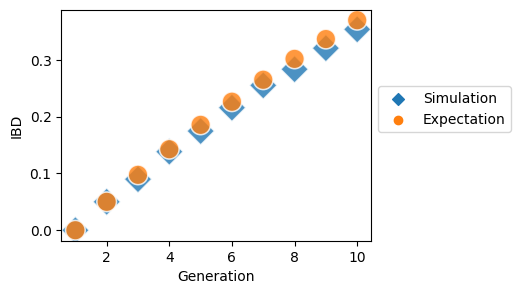

In [18]:
# it takes minutes

# results are stored in pandas DataFrame
cols = ['IBD', 'Generation', 'tag']
df1 = pd.DataFrame(index=[], columns=cols)

n_rep = 50
g_max = 10

# select by breeding values
for i in range(n_rep):  # 20 replicates
    aqua = aq.AquaBreeding(founder_size=(5, 5), 
                           progeny_size=(50, 50), 
                           chrom=(3, 100_000_000, 1.0, 1.0),
                           n_snp=2,
                           mean_phenotype=4.0,
                           effect_var=0.08, 
                           residual_var=0.12)
    aqua.snp_standard()
    aqua.mating_design(cross_design='full')

    for g in range(g_max):  # simulate from F1 to F10
        aqua.mating()
        aqua.breeding_value(blup='no')  # avoid calculating breeding value
        
        # get phenotype data
        tmp_p = aqua.get_ibd()
        record = pd.DataFrame([[np.mean(tmp_p), g, 'Simulation']], columns=cols)
        df1 = pd.concat([df1, record], ignore_index=True)
        
        if g == g_max-1:
            break
        aqua.selection(target='random', method='mass')  # random selection

cols = ['Generation', 'IBD', 'tag']
df2 = pd.DataFrame(index=[], columns=cols)
for g in range (g_max):
    tmp = df1[(df1['Generation']==g)]
    mean_phe = np.mean(tmp['IBD'])
    record = pd.DataFrame([[g+1, mean_phe, 'Simulation']], columns=cols)
    df2 = pd.concat([df2, record], ignore_index=True)
    
# theoretical expectation
for g in range(g_max):
    T = g+1
    F = 1.0 - (19.0/20.0)**(T-1)
    record = pd.DataFrame([[T, F, 'Expectation']], columns=cols)
    df2 = pd.concat([df2, record], ignore_index=True)
fig, ax = plt.subplots(figsize = (4, 3))
sns.scatterplot(x="Generation", y="IBD", hue="tag", style='tag', markers=('D', 'o'), s=200, alpha=0.8, data=df2)
plt.legend(loc=2, bbox_to_anchor=(1, 0.7))
plt.show()

## Check see if recombination works

In [101]:
aqua = aq.AquaBreeding(founder_size=(3, 3), 
                       progeny_size=(3, 3), 
                       chrom=(3, 100_000_000, 1.0, 1.0),
                       n_snp=2,
                       mean_phenotype=0.0,
                       effect_var=0.04, 
                       residual_var=0.12)
aqua.snp_standard()
aqua.mating_design(cross_design='full')

# print {n_show} founder individuals
print ('===========')
print ('chromosome = [[start segment, end segment, genotype], [start segment, end segment, genotype],...]')
print ('===========\nIndividual in the founder')
aqua.print_pop(target='founder', n_show=3)

aqua.mating()
print ('\n===========\nIndividual in the progeny')
aqua.print_pop(target='progeny', n_show=3)


chromosome = [[start segment, end segment, genotype], [start segment, end segment, genotype],...]
Individual in the founder
********** female **********
Individual ID = 0
  mother = -1
  father = -1
  0th chromosome
    maternal
      [1 100,000,000 0]
    paternal
      [1 100,000,000 1]
  1th chromosome
    maternal
      [1 100,000,000 0]
    paternal
      [1 100,000,000 1]
  2th chromosome
    maternal
      [1 100,000,000 0]
    paternal
      [1 100,000,000 1]
Individual ID = 1
  mother = -1
  father = -1
  0th chromosome
    maternal
      [1 100,000,000 2]
    paternal
      [1 100,000,000 3]
  1th chromosome
    maternal
      [1 100,000,000 2]
    paternal
      [1 100,000,000 3]
  2th chromosome
    maternal
      [1 100,000,000 2]
    paternal
      [1 100,000,000 3]
Individual ID = 2
  mother = -1
  father = -1
  0th chromosome
    maternal
      [1 100,000,000 4]
    paternal
      [1 100,000,000 5]
  1th chromosome
    maternal
      [1 100,000,000 4]
    paternal
     